# Explore the Model Performance in Inference and Test
In this notebook the Inference perfomed in the previous script `03_Inference.py` is assessed visually, as there are no annotations for the test-dev split.

In the second part of this notebook, the Average Precision per class is calculated for the validation split not used during the training process.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
from pathlib import Path
import matplotlib.patches as patches
import numpy as np
import sys
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import Dataset, DataLoader

sys.path.append('/dss/dsshome1/0A/di38tac/DOTA-Net/code')
from utils.training import get_best_checkpoint_path
from utils.dataset import DOTA_preprocessed, val_transforms, collate_fn


In [4]:
DOTA_SET = 'dota-subset' # possible values: dota-subset, dota
SPLIT = 'test-dev' # possible values: train, val, test-dev

ROOT = Path("/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022")
home = Path("/dss/dsshome1/0A/di38tac/DOTA-Net") # change this to your project directory to find the experiment files in the following

USER = "di38tac" # keep this if you want to use the data I preprocessed
USER_PATH = ROOT / f"users/{USER}"
DOTA_ROOT = USER_PATH / "DATA" / "SlidingWindow" / DOTA_SET / SPLIT 
INFERENCE_DIR = DOTA_ROOT / "Inference"

model_name = 'FasterRCNN'

## or upload model to github
EXPERIMENT_GROUP = "dota_FasterRCNN" # subfolder for model
EXPERIMENT_ID = "exp_003"
EXPERIMENT_DIR = home / model_name / f"experiments/{EXPERIMENT_GROUP}" / EXPERIMENT_ID

exp_fls = os.listdir(EXPERIMENT_DIR)
checkpoint = EXPERIMENT_DIR / exp_fls[0]

best_checkpoint_path = get_best_checkpoint_path(str(checkpoint))

In [5]:
out_path = INFERENCE_DIR / f"{model_name}-{EXPERIMENT_ID}_predictions.csv"
predictions_df = pd.read_csv(out_path)

## Visualize some predicitons
The test-dev set is utilized to visually interpret the performance of the model. Bounding Boxes are colored according to their class id. Bounding Boxes with a score lower than 0.5 are visualized with an alpha value of 0.5. See therefore the `plot_sample` function.

Click multiple times on the run button of the next kernel to browse through different image chips. The function selects a random image chip.

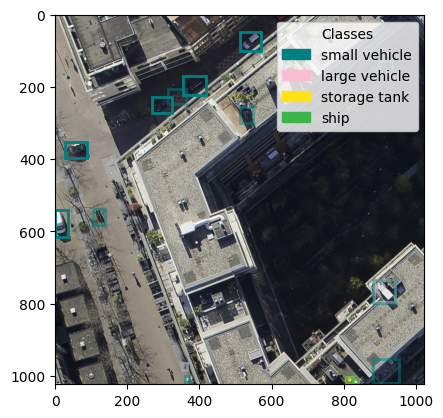

In [4]:
from utils.visualization import plot_sample

plot_sample(predictions_df, DOTA_ROOT)

## Evaluation of per Class Accuracy
As the model performs probably differently per class in terms of accuracy, the class accuracy was evaluated on the validation split of the dota-subset, as this was not used in training and has annotations (other than the test-dev split).

Therefore the model is loaded again from the checkpoint and the dataset and dataloader are initalized.

In [ ]:
# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

best_checkpoint_path = get_best_checkpoint_path(str(checkpoint))
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 19
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

checkpoint = torch.load(best_checkpoint_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

In [6]:
# setup dataset and dataloader
DOTA_SET = 'dota'
SPLIT = 'val'
DOTA_ROOT = USER_PATH / "DATA"/ "SlidingWindow" / DOTA_SET

test_dataset = DOTA_preprocessed(
    csv_file=DOTA_ROOT / 'val' / "ann/annotations.csv",
    root_img_dir=DOTA_ROOT / 'val' / "img",
    transform=val_transforms(),
    difficult=False
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False
)

In the following the model predicts on the validation set, while masking predictions with a score lower than the `VAL_SCORE_THRESHOLD`. To evaluate the performance per class the Average Precision is calculated per class with the `MeanAveragePrecision` Function of the `torchmetrics.detection.mean_ap` module. It is important to set `class_metrics` to True.

The cell does not need to be executed, you can simply access the resulting csv in the next cell.

In [7]:
from utils.training import prepare_map_targets, prepare_map_predictions
from torchmetrics.detection.mean_ap import MeanAveragePrecision
# Define score threshold to filter predicitons
VAL_SCORE_THRESHOLD = 0.5

# Initialize Mean Average Precision metric
mAP = MeanAveragePrecision(iou_type="bbox", class_metrics=True).to(device)

# Evaluate Model
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output, target in zip(outputs, targets):
            pred_boxes = output["boxes"].cpu().numpy()
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            mask = pred_scores > VAL_SCORE_THRESHOLD

            gt_boxes = target["boxes"].numpy()
            gt_labels = target["labels"].numpy()

            pred_data = [{
                "boxes": torch.tensor(pred_boxes[mask], dtype=torch.float32).to(device),
                "scores": torch.tensor(pred_scores[mask], dtype=torch.float32).to(device),
                "labels": torch.tensor(pred_labels[mask], dtype=torch.int64).to(device)
            }]
            gt_data = [{
                "boxes": torch.tensor(gt_boxes, dtype=torch.float32).to(device),
                "labels": torch.tensor(gt_labels, dtype=torch.int64).to(device)
            }]

            mAP.update(pred_data, gt_data)

# Compute mAP
map_result = mAP.compute()
print("Mean Average Precision (mAP) per class:")
for class_id, ap in enumerate(map_result['map_per_class']):
    print(f"Class {class_id+1}: {ap:.4f}")

map_value = map_result["map"].item()
print(f"\nMean Average Precision (mAP): {map_value:.4f}")

# Save Results
df = pd.DataFrame(data={"Class": range(1,19), 
                        "AP": map_result['map_per_class'],
                        "mAR": map_result['mar_100_per_class']})

df["mAP"] = map_value  # Add mAP as an extra column
out_path = INFERENCE_DIR / 'eval'
os.makedirs(out_path, exist_ok=True)
df.to_csv(out_path / f"{EXPERIMENT_ID}_{DOTA_SET}_{SPLIT}_class_mAPmAR.csv", index=False)
print(f"Evaluation results saved to {out_path}")

Mean Average Precision (mAP) per class:
Class 1: 0.6341
Class 2: 0.3549
Class 3: 0.4649
Class 4: 0.3604
Class 5: 0.6973
Class 6: 0.3630
Class 7: 0.4332
Class 8: 0.3080
Class 9: 0.1918
Class 10: 0.4194
Class 11: 0.2985
Class 12: 0.1683
Class 13: 0.3841
Class 14: 0.3401
Class 15: 0.1878
Class 16: 0.0000
Class 17: 0.2973
Class 18: 0.0000

Mean Average Precision (mAP): 0.3280
Evaluation results saved to /dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di38tac/DATA/SlidingWindow/dota-subset/test-dev/Inference/eval


The output has been written to a csv file and can now be visualized with the `plot_class_mAP` function. Average Precision and Average Recall by class are visualized in the following with the DOTA color-coding. The dashed horizontal line in the Average Precision Plot illustrates the mean Average Precision for the validation set.

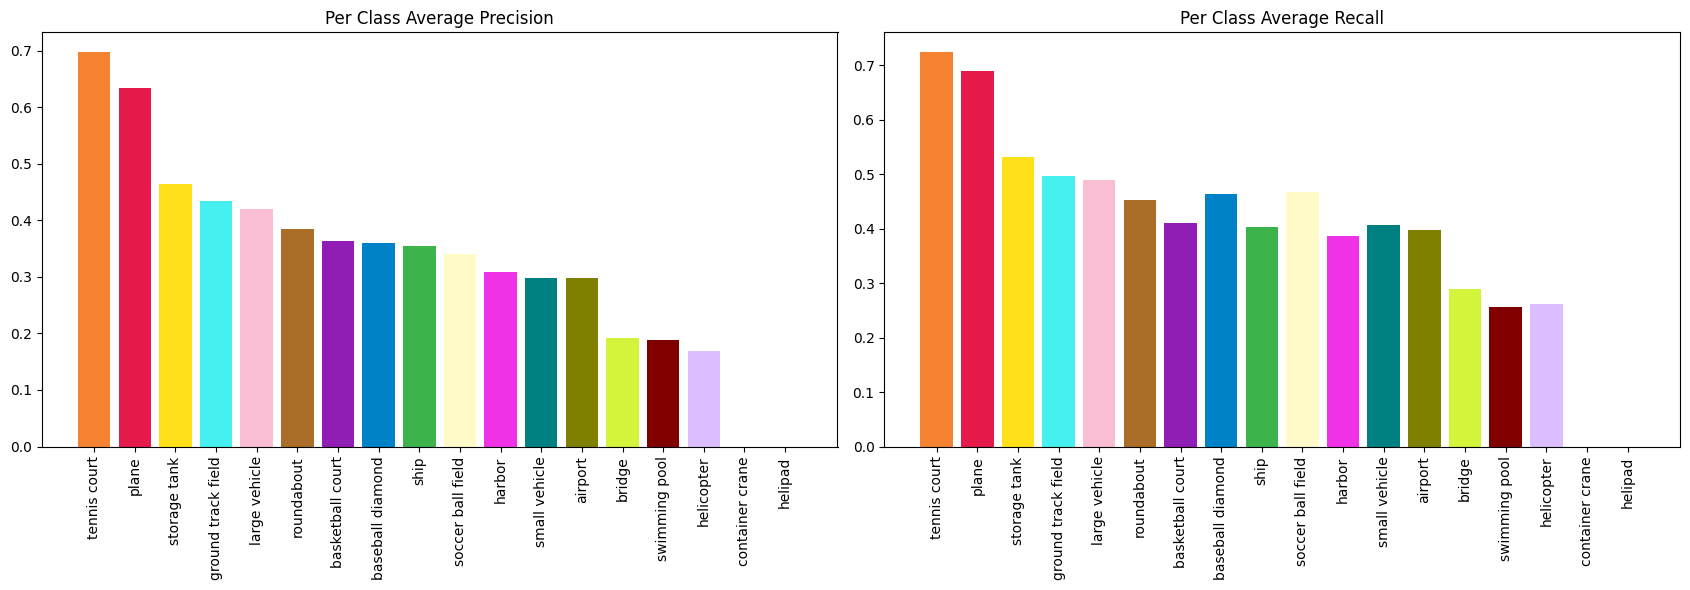

/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di38tac/DATA/SlidingWindow/dota-subset/test-dev/Inference/eval/exp_003_dota_val_class_mAPmAR.csv


In [1]:
from utils.visualization import plot_class_mAP
import pandas as pd

df_path = INFERENCE_DIR / 'eval' / f"{EXPERIMENT_ID}_{DOTA_SET}_{SPLIT}_class_mAPmAR.csv"
#df_path = '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di38tac/DATA/SlidingWindow/dota-subset/test-dev/Inference/eval/exp_003_dota_val_class_mAPmAR.csv'
df = pd.read_csv(df_path)
plot_class_mAP(df)
